<img src="../Fink_PrimaryLogo_WEB.jpg" width=300 />

# Fink case study: Gravitational waves

## Goal

The goal of this notebook is to show how Fink can contribute to multi-messenger and multi-wavelength science. This notebook includes queries for science related to **Gravitational waves**.

## Environment set up

To run this notebook, you need to import the following libraries (already installed in colab):

In [2]:
import requests
import io

import pandas as pd
import numpy as np
import healpy as hp

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

# Credible region sky map

Let's assume you want get all alerts falling inside a given LIGO/Virgo credible region sky map
(retrieved from the GraceDB event page, or distributed via GCN). You would
simply upload the sky map with a threshold, and Fink returns all alerts emitted
within `[-1 day, +6 day]` from the GW event inside the chosen credible region.
Concretely on [S200219ac](https://gracedb.ligo.org/superevents/S200219ac/view/):

In [4]:
!wget https://gracedb.ligo.org/api/superevents/S200219ac/files/bayestar.fits.gz .

--2023-05-02 21:43:05--  https://gracedb.ligo.org/api/superevents/S200219ac/files/bayestar.fits.gz
Resolving gracedb.ligo.org (gracedb.ligo.org)... 100.21.214.239, 52.25.57.90, 44.225.177.158
Connecting to gracedb.ligo.org (gracedb.ligo.org)|100.21.214.239|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 876685 (856K) [application/x-gzip]
Saving to: ‘bayestar.fits.gz’

bayestar.fits.gz    100%[===================>] 856.14K   824KB/s    in 1.0s    

2023-05-02 21:43:08 (824 KB/s) - ‘bayestar.fits.gz’ saved [876685/876685]

--2023-05-02 21:43:08--  http://./
Resolving . (.)... failed: Name or service not known.
wget: unable to resolve host address ‘.’
FINISHED --2023-05-02 21:43:08--
Total wall clock time: 2.8s
Downloaded: 1 files, 856K in 1.0s (824 KB/s)


In [5]:
# LIGO/Virgo probability sky maps, as gzipped FITS (bayestar.fits.gz)
# S200219ac on 2020-02-19T09:44:15.197173
fn = 'bayestar.fits.gz'

# GW credible region threshold to look for. Note that the values in the resulting
# credible level map vary inversely with probability density: the most probable pixel is
# assigned to the credible level 0.0, and the least likely pixel is assigned the credible level 1.0.
# Area of the 20% Credible Region:
credible_level = 0.2

# Query Fink
data = open(fn, 'rb').read()
r = requests.post(
    'https://fink-portal.org/api/v1/bayestar',
    json={
        'bayestar': str(data),
        'credible_level': credible_level,
        'output-format': 'json'
    }
)

pdf = pd.read_json(io.BytesIO(r.content))

You will get a Pandas DataFrame as usual, with all alerts inside the region (within `[-1 day, +6 day]`).
Here are some statistics on this specific event:

| `credible_level` | Sky area | number of alerts returned | Execution time |
|-----------|----------|---------------------------|----------------------|
| 0.2 | 81 deg2 | 121 | 2 to 5 seconds |
| 0.5 | 317 deg2 | 1137 | 10 to 15 seconds|
| 0.9 | 1250 deg2 | 2515 | > 60 seconds |

Here is the details of alert classification for a credible level of 0.2:

In [6]:
pdf.groupby('v:classification').count().sort_values('i:objectId', ascending=False)['i:objectId']

v:classification
Unknown                   104
QSO                        50
Solar System MPC           19
RRLyr                      17
Solar System candidate     10
Seyfert_1                   9
SN candidate                6
V*                          6
EB*                         4
AGN                         1
BLLac                       1
Candidate_RRLyr             1
HB*                         1
PulsV*delSct                1
Radio                       1
Star                        1
Name: i:objectId, dtype: int64

Most of the alerts are actually catalogued. Finally, you can overplot alerts on the sky map:

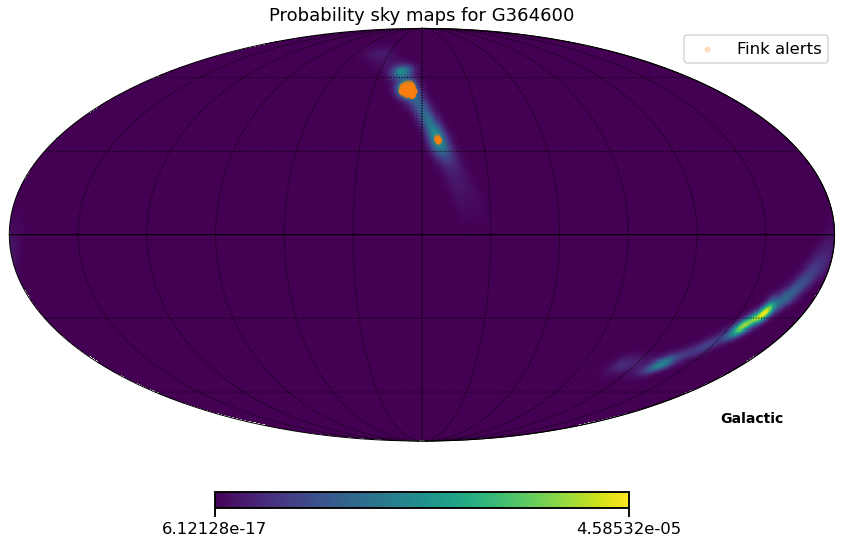

In [12]:
fig = plt.figure(0, figsize=(12, 15))

hpx, header_ = hp.read_map(fn, h=True, field=0)
header = {i[0]: i[1] for i in header_}

title = 'Probability sky maps for {}'.format(header['OBJECT'])
hp.mollview(hpx, coord='G', title=title, rot=180, fig=0)

if len(pdf) > 0:
    hp.projscatter(
        pdf['i:ra'],
        pdf['i:dec'],
        lonlat=True,
        marker='.',
        color='C1',
        alpha=0.2, label='Fink alerts'
    )

hp.graticule()
plt.legend()
plt.show()

# Summary
In this notebook we have searched for possible MMA optical counterparts:
- Querying Fink's API for alerts falling into a credible region sky map.

The API servive is not a real-time database. For real time services please use the live-stream. However, the API is useful for offline searches and analysis!

### An issue to report, or a question to ask: contact@fink-broker.org !